In [129]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from sklearn.utils import shuffle
from keras.utils import plot_model
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

In [130]:
class EmbModel(tf.keras.Model):
    def __init__(self, useridlength, category_length):
        super(EmbModel, self).__init__()
        self.d_steps = 1
        self.useridlength = useridlength
        self.category_length = category_length
        self.model = self.init_model()
        print(self.useridlength)
        
    def call(self, inputs):
        return
    
    def init_model(self):
        poi_latitude_input = keras.layers.Input(shape=(1,), name='poi_latitude')
        poi_longitude_input = keras.layers.Input(shape=(1,), name='poi_longitude')
        poi_concat_input = tf.keras.layers.Concatenate(axis=-1)([poi_latitude_input, poi_longitude_input])
        #input_length:  #This is the length of input sequences, as you would define for any input layer of a Keras model. 
                        #For example, if all of your input documents are comprised of 1000 words, this would be 1000
        #input_dim: 
                        #This is the size of the vocabulary in the text data. 
                        #For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
        poi_dense = keras.layers.Dense(8)(poi_concat_input)
        poi_reshape = keras.layers.Reshape((1, 8))(poi_dense)
        
        category_input = keras.layers.Input(shape=(1), name='category_input')
        category_emb = keras.layers.Embedding(self.category_length, 8)(category_input)    
        category_concat = tf.keras.layers.Concatenate(axis=-1)([category_emb, poi_reshape])
    
        user_input = keras.layers.Input(shape=(1,), name='user_id')
        user_emb = keras.layers.Embedding(self.useridlength, 16)(user_input)
        #user_reshape = layers.Reshape((1, 256))(user_emb)
                                    
        dot = keras.layers.Dot(axes=(2))([category_concat, user_emb])
            
        model = Model([category_input, poi_latitude_input, poi_longitude_input, user_input], dot)
        model.summary()
        return model
    
    def compile_model(self, optimizer):
        super(EmbModel, self).compile(run_eagerly=True)
        self.optimizer = optimizer
        
    def train_step(self, data):
        if len(data) == 3:
            real_data, labels, sample_weight = data
        else:
            sample_weight = None
            real_data, labels = data
        cat_data = real_data[0]
        lat_data = real_data[1]
        long_data = real_data[2]
        user_data = real_data[3]

        for i in range(self.d_steps):
            with tf.GradientTape() as tape:
                
                #print(latlong_data[0])
                #print(latlong_data[1])
                #print(user_data)
                
                dotproduct = self.model([cat_data, lat_data, long_data, user_data])
                #print(dotproduct)
                # Loss function = ||S-GroundTruth|| 
                loss = tf.math.abs(tf.subtract(tf.cast(dotproduct, tf.float64), labels))
                #print(loss)
            d_gradient = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(d_gradient, self.model.trainable_variables))
        return {'loss': loss}
    
    def predict_step(self, data):
        sample_weight = None
        cat_data = data[0]
        lat_data = data[1]
        long_data = data[2]
        user_data = data[3]
        return self.model([cat_data, lat_data, long_data, user_data])
    
    def load_model(self, path):
        self.model = keras.models.load_model(path)

In [131]:
model = EmbModel(1, 1)

encoding_array = np.load(r"C:\Users\lasse\Desktop\RecommenderDL\datasets\encoding_array_experimental.npy", allow_pickle=True)
encoding_array = dict(enumerate(encoding_array.flatten(), 1))[1]
print(encoding_array)

model = keras.models.load_model(r'C:\Users\lasse\Desktop\RecommenderDL\models\model_experimental')
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
model.compile(
    optimizer
)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
poi_latitude (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
poi_longitude (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 2)            0           poi_latitude[0][0]               
                                                                 poi_longitude[0][0]              
__________________________________________________________________________________________________
category_input (InputLayer)     [(None, 1)]          0                                 

In [132]:
x_test_df = pd.read_csv(r'C:\Users\lasse\Desktop\RecommenderDL\datasets\y_train_df_512.csv', sep=',', names=['User','Latitude','Longitude', '0'], encoding='latin-1')[1:]
y_test_df = pd.read_csv(r'C:\Users\lasse\Desktop\RecommenderDL\datasets\y_test_df_512.csv', sep=',', names=['0'], encoding='latin-1')[1:]
venue_cols = ['poi_id', 'latitude', 'longitude', 'category', 'country_code']
den_pois = pd.read_csv(r'C:\Users\lasse\Desktop\RecommenderDL\datasets\Den_pois.csv', sep=',', names=venue_cols, encoding='latin-1')
print(x_test_df)
print(y_test_df)
x_test_df.rename(columns = {'0':'category'}, inplace = True)
y_test_df.rename(columns = {'0':'ground_truth'}, inplace = True)
dataset = pd.concat([x_test_df, y_test_df], axis=1)
print(dataset)

C:\Users\lasse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


              User   Latitude  Longitude      0
1.0       203662.0  55.671813  12.561193   35.0
2.0       212997.0  55.703528  12.529708  148.0
3.0       263940.0  55.613584   12.46681   89.0
4.0       230978.0  55.676713  12.572082  135.0
5.0        82431.0  55.690691  12.560402    7.0
...            ...        ...        ...    ...
328779.0   18933.0   55.71347   12.46753   97.0
328780.0   83478.0  55.659747   12.59038   90.0
328781.0  137446.0  55.660757  12.589555   76.0
328782.0  158620.0  55.638461  12.610049    2.0
328783.0  175270.0   55.67829  12.573485   66.0

[328783 rows x 4 columns]
            0
1.0       0.0
2.0       0.0
3.0       0.0
4.0       0.0
5.0       0.0
...       ...
328779.0  0.0
328780.0  0.0
328781.0  0.0
328782.0  0.0
328783.0  0.0

[328783 rows x 1 columns]
              User   Latitude  Longitude  category  ground_truth
1.0       203662.0  55.671813  12.561193      35.0           0.0
2.0       212997.0  55.703528  12.529708     148.0           0.0
3.0    

<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<ipython-input-88-358738812ae8>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  categories_list = [['Scandinavian Restaurant']


TypeError: list indices must be integers or slices, not str

In [28]:
def intersect(self, nums1, nums2):
    """
    :type nums1: List[int]
    :type nums2: List[int]
    :rtype: List[int]
    """
    m = {}
    if len(nums1)<len(nums2):
        nums1,nums2 = nums2,nums1
    for i in nums1:
        if i not in m:
            m[i] = 1
        else:
            m[i]+=1
    result = []
    for i in nums2:
        if i in m and m[i]:
            m[i]-=1
            result.append(i)
    return result

In [134]:
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative = 0
change = 0
scores = []
number = 0
totalIntersection = 0
categories_numpy=np.load(r"C:\Users\lasse\Desktop\RecommenderDL\datasets\categories_numpy.npy", allow_pickle=True)

users = x_test_df.copy()
users.drop_duplicates(subset ="User", keep = 'first', inplace = True)

#test = categories1.loc[(categories1['user_id'] == 71191.0) & (categories1['latitude'] == 55.737798) & (categories1['longitude'] == 12.522954)]

for index, row in users.iterrows():
    print("ITERATION: ", index)
    user = float(x_test_df.loc[index, 'User'])
    #print("User: ", user, "Type: ", type(user))
    #FOR HVER USER:
        #Get pois which the user has visited.
    test = dataset.loc[(dataset['User'] == user) & (dataset['ground_truth'] == 1)]
    user = encoding_array.get(user)
    if test.empty:
        continue
        #Calculate a score for each poi
    for index, row in den_pois.iterrows():
        #Get lat
        lat = float(den_pois.loc[index, 'latitude'])
        long = float(den_pois.loc[index, 'longitude'])
        cat = den_pois.loc[index, 'category']
        #cat = category['category']
        index = np.where(categories_numpy == [cat])[0][0]
        long_tf = tf.convert_to_tensor([long],dtype=None, dtype_hint=None, name=None)
        lat_tf = tf.convert_to_tensor([lat],dtype=None, dtype_hint=None, name=None)
        user_tf = tf.convert_to_tensor([user],dtype=None, dtype_hint=None, name=None)
        cat_tf = tf.convert_to_tensor([index],dtype=None, dtype_hint=None, name=None)
        score = model([cat_tf, lat_tf, long_tf, user_tf])
        scores.append([score[0][0][0].numpy(), lat, long])
    #Sort after N best scores
    scores.sort()
    scores.reverse()
    #Inersection between the N best scores and the pois which the user has visited.
    hehe = len(test)
    scores = scores[:hehe]
    other = []
    intersection = 0
    for index, row in test.iterrows():
        lat = float(test.loc[index, 'Latitude'])
        long = float(test.loc[index, 'Longitude'])
        for i in scores:
            if (lat == float(i[1])) and (long == float(i[2])):
                intersection += 1
    print(intersection)
    totalIntersection += intersection
    number += 1

print("Final outcome:")
total = totalIntersection / number
print(total)
        
        
        
        
        
    #result = intersect(test, scores)
    #Calculate precision and recall
    

ITERATION:  1.0
ITERATION:  2.0
ITERATION:  3.0
ITERATION:  4.0
0
ITERATION:  5.0
ITERATION:  6.0
ITERATION:  7.0
ITERATION:  8.0
ITERATION:  9.0
ITERATION:  10.0
ITERATION:  11.0
ITERATION:  12.0
ITERATION:  13.0
ITERATION:  14.0
0
ITERATION:  15.0
ITERATION:  16.0
ITERATION:  17.0
0
ITERATION:  18.0
ITERATION:  19.0
ITERATION:  20.0
ITERATION:  21.0
0
ITERATION:  22.0
ITERATION:  23.0
ITERATION:  24.0
ITERATION:  25.0
ITERATION:  26.0
ITERATION:  27.0
ITERATION:  28.0
ITERATION:  29.0
ITERATION:  30.0
ITERATION:  31.0
0
ITERATION:  32.0
ITERATION:  33.0
ITERATION:  34.0
ITERATION:  35.0
0
ITERATION:  36.0
0
ITERATION:  37.0
ITERATION:  38.0
0
ITERATION:  39.0
ITERATION:  40.0
0
ITERATION:  41.0
0
ITERATION:  42.0
0
ITERATION:  43.0
0
ITERATION:  44.0
ITERATION:  45.0
ITERATION:  46.0
ITERATION:  47.0
ITERATION:  48.0
ITERATION:  49.0
ITERATION:  50.0
ITERATION:  51.0
ITERATION:  52.0
0
ITERATION:  53.0
ITERATION:  55.0
0
ITERATION:  56.0
ITERATION:  57.0
0
ITERATION:  58.0
ITERATION:

In [121]:
print("Loading checkins")
checkin_cols = ['user_id', 'poi_id', 'timestamp', 'timezone']
checkins = pd.read_csv(r'C:\Users\lasse\Desktop\RecommenderDL\datasets\Den_checkins.csv', sep=',', names=checkin_cols, encoding='latin-1').dropna(axis=1)

print("Loading POIs")
venue_cols = ['poi_id', 'latitude', 'longitude', 'category', 'country_code']
pois = pd.read_csv(r'C:\Users\lasse\Desktop\RecommenderDL\datasets\Den_pois.csv', sep=',', names=venue_cols, encoding='latin-1')

c = pd.DataFrame(checkins, columns=['user_id', 'poi_id'])
p = pd.DataFrame(pois, columns=['poi_id', 'latitude', 'longitude', 'category'])

categories1 = p.merge(c, on='poi_id')


Loading checkins
Loading POIs


In [135]:
print(len(users))

1298


In [126]:
for index, row in x_test_df.iterrows():
    long = float(x_test_df.loc[index, 'longitude'])
    lat = float(x_test_df.loc[index, 'latitude'])
    user = float(x_test_df.loc[index, 'Users'])
    cat = float(x_test_df.loc[index, 'category'])
    groundtruth = y_test_df.loc[index, 'ground_truth']
    
    if groundtruth == 0:
        test = categories1.loc[(categories1['user_id'] == user) & (categories1['latitude'] == lat) & (categories1['longitude'] == long)]
        boolean = test.empty
        if not boolean:
            print("ERROR: == 0")
            print(index)
            print(user)
            print(lat)
            print(long)
            print(groundtruth)
            user = encoding_array.get(user)
            long = tf.convert_to_tensor([long],dtype=None, dtype_hint=None, name=None)
            lat = tf.convert_to_tensor([lat],dtype=None, dtype_hint=None, name=None)
            user = tf.convert_to_tensor([user],dtype=None, dtype_hint=None, name=None)
            cat = tf.convert_to_tensor([cat],dtype=None, dtype_hint=None, name=None)
    elif groundtruth == 1:
        test = categories1.loc[(categories1['user_id'] == user) & (categories1['latitude'] == lat) & (categories1['longitude'] == long)]
        boolean = test.empty
        if boolean:
            print("ERROR: == 1")
            print(index)
            print(user)
            print(lat)
            print(long)
            print(groundtruth)

ERROR: == 1
35.0
11352.0
55.677011
12.538932
1.0
ERROR: == 1
57.0
5194.0
55.706813
12.512385
1.0
ERROR: == 0
187.0
70659.0
55.677063
12.568179
0.0
ERROR: == 0
324.0
154044.0
55.661622
12.604347
0.0
ERROR: == 0
448.0
9912.0
55.68315
12.571106
0.0
ERROR: == 1
652.0
105522.0
55.670952
12.567724
1.0
ERROR: == 0
671.0
80726.0
55.628444
12.649469
0.0
ERROR: == 1
796.0
166461.0
55.698377
12.594665
1.0
ERROR: == 0
815.0
3166.0
55.660775
12.591308
0.0
ERROR: == 1
961.0
166119.0
55.713177
12.539373
1.0
ERROR: == 1
1245.0
159905.0
55.67946
12.575359
1.0
ERROR: == 1
1337.0
46963.0
55.709244
12.583228
1.0
ERROR: == 1
1646.0
29817.0
55.628764
12.648709
1.0
ERROR: == 1
1674.0
11352.0
55.68089
12.541894
1.0
ERROR: == 1
1790.0
5194.0
55.683923
12.569704
1.0
ERROR: == 0
2136.0
8018.0
55.683748
12.566961
0.0


KeyboardInterrupt: 

In [128]:
user = 11352.0
lat = 55.677011
long = 12.538932

test = categories1.loc[(categories1['latitude'] == lat) & (categories1['longitude'] == long)]
print(test)

                        poi_id   latitude  longitude     category  user_id
4250  4b6d92bcf964a520697d2ce3  55.677011  12.538932  Record Shop   209872
4251  4b6d92bcf964a520697d2ce3  55.677011  12.538932  Record Shop     7978


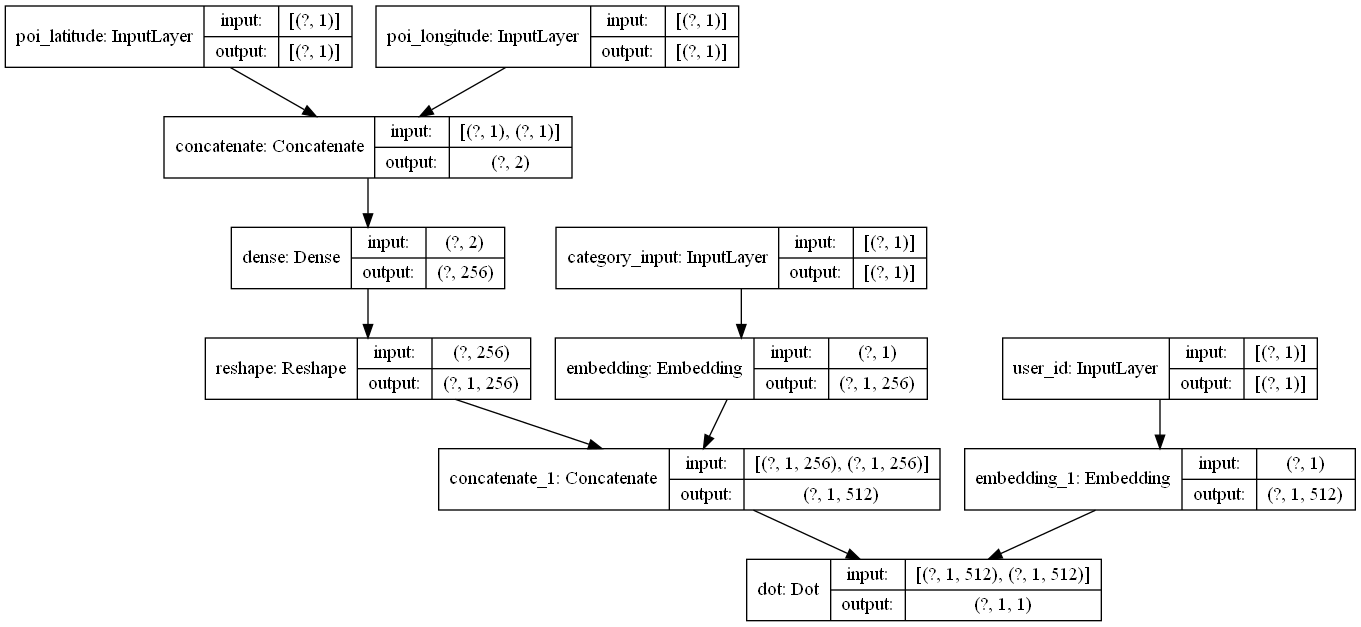

In [137]:
tf.keras.utils.plot_model(model, to_file=r'C:\Users\lasse\Music\model.png', show_shapes=True)